# Performance Evaluation

The first part of this notebook summarizes the conventional performance measures for an investment fund. The second part does a "style analysis" to find out how the fund has changed its portfolio weights over time.

## Load Packages and Extra Functions

In [1]:
using Printf, Dates, DelimitedFiles, Statistics

include("jlFiles/printmat.jl")
include("jlFiles/OlsM.jl");

In [2]:
using Plots

gr(size=(480,320))
default(fmt = :png)

# Loading Data

The weekly return data for the mutual funds that we will evaluate are in the matrix `R`, the benchmarks (a number of returns on different asset indices) in `Rb` and the riskfree rate in the vector `Rf`.

### A Remark on the Code
In the code below, `x` from `readdlm()` is an `Any` matrix (the first column are strings, the other columns are numbers). It often helps to convert to the right type. For the numbers in column `2:end` we can do that by `Float64.(x[:,2:end])` (or alternatively by `convert.(Float64,x[:,2:end])`).

In [3]:
(x,header) = readdlm("Data/Fin1PerfEvalEmp.csv",',',header=true)

(IndNames,FundNames) = (header[2:9],header[10:11])     #names of variables

dN        = Date.(x[:,1],"yyyy-mm-dd")
(Rb,R,Rf) = (Float64.(x[:,2:9]),Float64.(x[:,10:11]),Float64.(x[:,12]))  #benchmarks, funds, riskfree

printblue("The data is weekly. The first 4 observations are:")
printmat(first(dN,4))

The data is weekly. The first 4 observations are:
1999-01-15
1999-01-22
1999-01-29
1999-02-05



# Performance Evaluation

The next few cells report a number of different performance measures for the funds. We annualize the weekly return statistics by multiplying by $\sqrt{52}$ or $52$, depending on the measure. In many cases, we also convert the numbers to percentage (%) by multiplying by $100$.

## Average and Standard Deviation of Excess Returns

### A Remark on the Code

We use `Re` to denote excess returns for the funds and `Reₘ` the excess return of the market. (`Rᵉₘ` looks ugly, so we avoid it.) Similarly for `μe` and `μeₘ`.

In [4]:
Re  = R .- Rf           #excess returns of the funds
Reₘ = Rb[:,1] - Rf      #excess returns of the marketₘ (S&P 500)

μe = mean(Re,dims=1)        #average excess returns of funds, 1xn
σ  = std(Re,dims=1)         #std, 1xn

μeₘ = mean(Reₘ)             #average excess returns of market
σₘ  = std(Reₘ)

xut = hcat([μeₘ;μe']*52*100)
printmat(xut;colNames=["ERᵉ (annual. %)"],rowNames=["Market";FundNames])

                                 ERᵉ (annual. %)
Market                                4.696
Putnam Asset Allocation: Growth A     4.143
Vanguard Wellington                   5.234



## Sharpe Ratio and M²

The Sharpe ratio (SR) is $\mu^e/\sigma$, where $\mu^e$ is the average excess return and $\sigma$ the standard deviation of the excess return. The $M^2$ is the difference of the SRs of a fund and the market, scaled by the standard deviation of the market.

Mean returns are annualized by $\times 52$ and standard deviations by $\times \sqrt{52}$, so a SR by $\times \sqrt{52}$.

In [5]:
SR  = (μe./σ)*sqrt(52)              #Sharpe ratio
SRₘ = (μeₘ/σₘ)*sqrt(52)

MM  = (SR .- SRₘ)*σₘ*sqrt(52)*100   #MM since M²ₘ looks ugly
MMₘ = 0                             #(SRₘ.-SRₘ)*σₘ=0

xut = hcat([μeₘ;μe']*52*100,[SRₘ;SR'],[MMₘ;MM'])
printmat(xut;colNames=["ERe","SR","M²"],rowNames=["Market";FundNames])

                                        ERe        SR        M²
Market                                4.696     0.268     0.000
Putnam Asset Allocation: Growth A     4.143     0.283     0.265
Vanguard Wellington                   5.234     0.489     3.865



## Appraisal Ratio

Estimate a single index model

$R^e_t = \alpha + \beta R^e_{mt} + \epsilon_t$ 

The appraisal ratio (AR) is $\alpha/\mathrm{Std}(\epsilon)$.

### A Remark on The Code
- The `OlsM(y,x)` function (included above) does a regression for each of the $n$ columns in `y` on the same set of $K$ regressors in `x`. It returns ($K\times n$) coefficients `b` and ($1\times n$) standard deviations of the residuals `σ`.

In [6]:
T = size(Re,1)

(b,σₑ) = OlsM(Re,[ones(T) Reₘ])   #OLS regression for each column in Reₚ
(α,β)  = (b[1:1,:],b[2:2,:])      #intercept and slopes (1xn) 

AR  = (α*52*100)./(σₑ*sqrt(52)*100)   #α and σₑ are 1xn
ARₘ = 0

xut = [ARₘ;AR']
printmat(xut;colNames=["AR"],rowNames=["Market";FundNames])

                                         AR
Market                                0.000
Putnam Asset Allocation: Growth A     0.092
Vanguard Wellington                   0.671



## Treynor's Ratio and T²

Treynor's ratio is $\mu^e/\beta$, where $\beta$ is the slope from the single index regression.

In [7]:
TR  = 52*100*μe./β
TRₘ = 52*100*μeₘ/1           #market has β=1

TT = TR .- μeₘ*52*100        #T²ₘ looks ugly
TTₘ = 0                      #TRₘ - μeₘ*52*100

xut = hcat([TRₘ;TR'],[TTₘ;TT'])
printmat(xut,colNames=["TR","T²"],rowNames=["Market";FundNames])

                                         TR        T²
Market                                4.696     0.000
Putnam Asset Allocation: Growth A     5.193     0.497
Vanguard Wellington                   9.158     4.462



# Style Analysis

The regression is $Y = \sum_{j=1}^{K}b_j X_j + \varepsilon$,
               where $0 <= b_j$ and $\sum_{j=1}^{K}b_j = 1$. 
               
Write the sum of squared residuals of the regression as

$(Y-Xb)'(Y-Xb) = Y'Y - 2Y'Xb + b'X'Xb$.

Only the two last terms matter for the choice of $b$.

### A Remark on the Code
- The code uses the [OSQP.jl](https://github.com/osqp/OSQP.jl) package which solves problems of the type: $\min 0.5b'Pb + q'b$ subject to $l \leq Ab \leq u$. 
- The restricted regression (above) can easily be written in this form by letting $P=X'X/T$ and $q=-X'Y/T$. These choices give the loss function $0.5b'X'Xb/T - Y'Xb/T$, which is proportional ($0.5/T$) to the last two terms in the sum of squared residuals. Dividing by $T$ improves the numerical stability.
- The $A$ matrix is used to construct the restrictions ($b$ sums to 1 and $0 \leq b \leq 1$).

In [8]:
using LinearAlgebra, SparseArrays, OSQP   #OSQP needs SparseArrays

In [9]:
"""
    StyleAnalysisPs(Y,X)


# Input:
- `Y::Vector`:          T-vector, returns of a fund
- `X ::Matrix`:         TxK matrix, returns on m benchmarks

 # Output:
- `b_sa::Vector`:       K-vector, restricted regression coefficients
- `b_ls::Vector`:       K-vector, OLS regression coefficients

"""
function StyleAnalysisPs(Y,X)

    (T,K) = (size(X,1),size(X,2))
    b_ls = X\Y                          #LS estimate, no restrictions

    settings = Dict(:verbose => false)
    P = X'X/T                            
    q = -X'Y/T
    A = [ones(1,K);I]                  #1st restriction: sum(b)=1, 
    l = [1;zeros(K)]                   #the rest: 0<=b<=1
    u = [1;ones(K)]
    
    settings = Dict(:verbose => false)
    model = OSQP.Model()    #(P,A) must be `Sparse`, (q,l,u) vectors of `Float64`
    OSQP.setup!(model; P=sparse(P), q=q, A=sparse(A), l=l, u=u, settings...)
    result = OSQP.solve!(model)
    b_sa = result.info.status == :Solved ? result.x : NaN  
      
    return b_sa, b_ls

end

StyleAnalysisPs

The next cell makes a "style analysis regression" based on the entire sample. The dependent variable is the first mutual fund in R (see data loading) and the regressors include all indices (again, see data loading).

In [10]:
(b,b_ls) = StyleAnalysisPs(R[:,1],Rb)

printblue("OLS and style analysis coeffs:")
colNames = ["OLS","Restricted LS"]
xut      = [b_ls b;sum([b_ls b],dims=1)]
printmat(xut;colNames,rowNames=[IndNames;"sum"],width=15)

printred("Notice that the restricted LS has (approximately) no negative coeffs and that sum(coeffs) = 1")

OLS and style analysis coeffs:
                                      OLS  Restricted LS
S&P 500                             0.429          0.429
S&P MidCap 400                      0.086          0.087
S&P Small Cap 600                   0.067          0.069
World Developed - Ex. U.S.          0.199          0.203
Emerging Markets                    0.054          0.058
US Corporate Bonds                  0.176          0.071
U.S. Treasury Bills                 0.085          0.083
US Treasury                        -0.151         -0.000
sum                                 0.944          1.000

Notice that the restricted LS has (approximately) no negative coeffs and that sum(coeffs) = 1


# Redo the Style Analysis on a Moving Data Window 

of size `WinSize` (see below). Then plot to see how the coefficients change over time. 

In [11]:
(T,K)   = size(Rb)
WinSize = 104

b = fill(NaN,T,K)
for t = (WinSize+1):T
    #local vv                 #local/global is needed in script
    vv     = (t-WinSize):t    #moving data window
    b[t,:] = StyleAnalysisPs(R[vv,1],Rb[vv,:])[1]
end

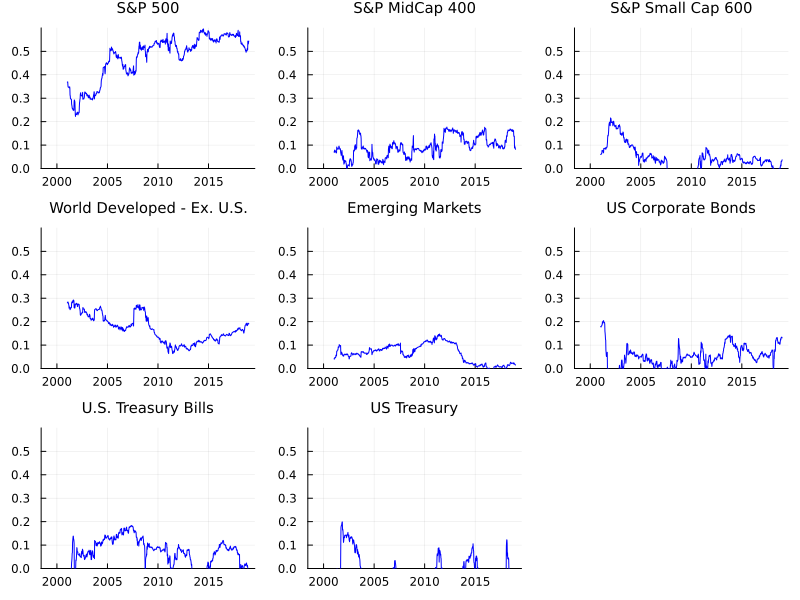

In [12]:
xTicksLoc = [Date(2000);Date(2005);Date(2010);Date(2015)]
xTicksLab = Dates.format.(xTicksLoc,"Y")

p1 = plot( dN,b,
           layout = @layout[a a a;a a a;a a _],   #_ to get blank subplot
           legend = false,
           size = (800,600),
           linecolor = :blue,
           xticks = (xTicksLoc,xTicksLab),
           ylims = (0,0.6),
           title = reshape(string.(IndNames),1,:),
           titlefontsize = 10 )
display(p1)